# Tokenization Experiments

## 1. Import Necessary Libraries and Packages

In [1]:
# Import necessary libraries
from transformers import AutoTokenizer, AutoModel

/Users/juliusbijkerk/Documents/uulola/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Model with Default Tokenizer and Vocabulary

In [2]:
# Specify model to load from Hugging Face
model_name = "bert-base-uncased" 

# Load tokenizer: vocabulary and tokenization function
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model
model = AutoModel.from_pretrained(model_name)

# Extract vocabulary from tokenizer
vocab = tokenizer.get_vocab()

## 3. Inspect Vocabulary

In [3]:
# Expected size of vocabulary V = 30522
print("Vocabulary size:", len(vocab))

# Some examples of vocabulary items
print("Sample vocabulary items:")
for item in list(vocab.items())[:10]:
    print(item)

Vocabulary size: 30522
Sample vocabulary items:
('##rail', 15118)
('savings', 10995)
('##eu', 13765)
('chariot', 23507)
('##isse', 23491)
('文', 1861)
('€', 1574)
('neon', 16231)
('exceed', 13467)
('fairies', 20182)


## 4. Define Custom Tokenization Function

### Tokenization Function based on whitespace

In [7]:
def custom_tokenization_function(text):
    """
    Tokenize the input text based on a custom tokenization function

    Args:
        text (str): The input text to tokenize

    Returns:
        list: A list of tokens
    """
    tokens = text.split()
    return [token for token in tokens]

## 5. Load and Split Dataset

In [ ]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("snli")

# Access train, validation, and test splits
train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

# Split test data into premises and hypotheses
test_premises = test_data["premise"]
test_hypotheses = test_data["hypothesis"]

print(test_data)
print(test_data[0])


# Tokenize the first premise and hypothesis
premise_tokens = custom_tokenization_function(test_premises)
hypothesis_tokens = custom_tokenization_function(test_hypotheses)

# Display the tokenized premise and hypothesis
print("Premise tokens:", premise_tokens)
print("Hypothesis tokens:", hypothesis_tokens)

# Tokenize the first premise and hypothesis using the custom tokenizer
premise_tokens = custom_tokenization_function(test_premises[0], vocab)
hypothesis_tokens = custom_tokenization_function(test_hypotheses[0], vocab)

# Display the tokenized premise and hypothesis
print("Premise tokens:", premise_tokens)
print("Hypothesis tokens:", hypothesis_tokens)

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 10000
})
{'premise': 'This church choir sings to the masses as they sing joyous songs from the book at a church.', 'hypothesis': 'The church has cracks in the ceiling.', 'label': 1}


TypeError: custom_tokenization_function() takes 1 positional argument but 2 were given

In [23]:
# Show test_data information
print(test_data)

# Conversion table for labels
conversion_table = {-1: '-1: no label', 0: '0: entailment', 1: '1: neutral', 2: '2: contradiction'}
print("Label names:")
print(conversion_table)

# Split test data into premises and hypotheses
test_premises = test_data["premise"]
test_hypotheses = test_data["hypothesis"]
test_labels = test_data["label"]

# Display the first 5 examples 
zipped_data = list(zip(test_premises, test_hypotheses, test_labels))
for example in zipped_data[:5]:
    print(example)

print('\n')

print(len(test_premises))
print(len(test_hypotheses))
print(len(test_labels))

print(test_premises[0])
print(test_hypotheses[0])
print(test_labels[0])

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 10000
})
Label names:
{-1: '-1: no label', 0: '0: entailment', 1: '1: neutral', 2: '2: contradiction'}
('This church choir sings to the masses as they sing joyous songs from the book at a church.', 'The church has cracks in the ceiling.', 1)
('This church choir sings to the masses as they sing joyous songs from the book at a church.', 'The church is filled with song.', 0)
('This church choir sings to the masses as they sing joyous songs from the book at a church.', 'A choir singing at a baseball game.', 2)
('A woman with a green headscarf, blue shirt and a very big grin.', 'The woman is young.', 1)
('A woman with a green headscarf, blue shirt and a very big grin.', 'The woman is very happy.', 0)


10000
10000
10000
This church choir sings to the masses as they sing joyous songs from the book at a church.
The church has cracks in the ceiling.
1


## 6. Inspect Dataset

Train length: 550152
Validation length: 10000
Test length: 10000
First 10 examples from the test set:
{'premise': ['This church choir sings to the masses as they sing joyous songs from the book at a church.', 'This church choir sings to the masses as they sing joyous songs from the book at a church.', 'This church choir sings to the masses as they sing joyous songs from the book at a church.', 'A woman with a green headscarf, blue shirt and a very big grin.', 'A woman with a green headscarf, blue shirt and a very big grin.', 'A woman with a green headscarf, blue shirt and a very big grin.', 'An old man with a package poses in front of an advertisement.', 'An old man with a package poses in front of an advertisement.', 'An old man with a package poses in front of an advertisement.', 'A statue at a museum that no seems to be looking at.'], 'hypothesis': ['The church has cracks in the ceiling.', 'The church is filled with song.', 'A choir singing at a baseball game.', 'The woman is young.

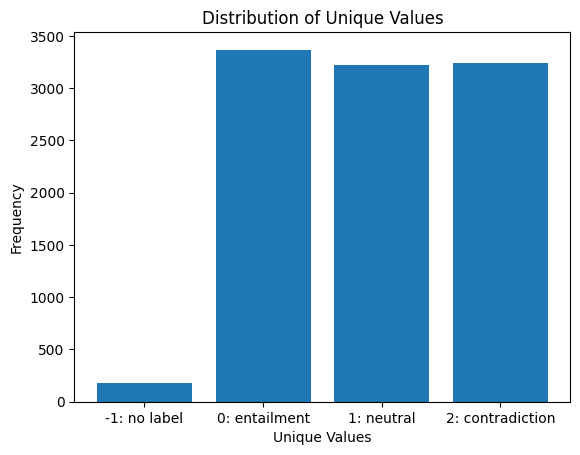

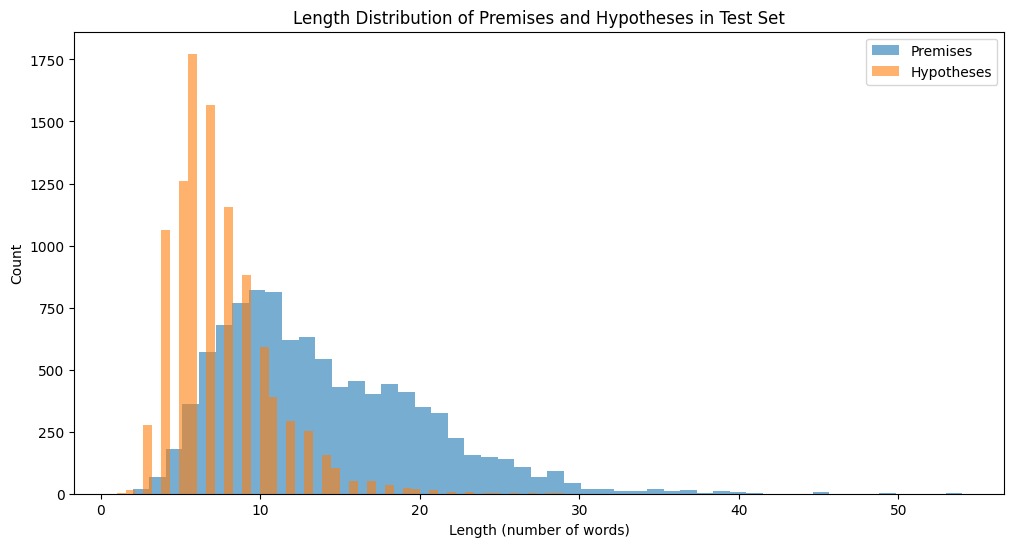

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Lengths of train, validation, and test splits
print("Train length:", len(train_data))
print("Validation length:", len(validation_data))
print("Test length:", len(test_data))

# Display the first example from the test set
print("First 10 examples from the test set:")
print(test_data[:10])
print(type(test_data[:10]))
print("1st Example Premise:", test_data[0]['premise'])
print("1st Example Hypothesis:", test_data[0]['hypothesis'])

# Display the number of examples in the test set
print("Number of examples in the test set:", len(test_data))

# Display the distribution of labels in the test set
label_counts = test_data["label"]

# Count the frequency of each unique value
counter = Counter(label_counts)

# Extract the unique values and their counts
labels, counts = zip(*counter.items())

# Plot distribution of labels
plt.bar(labels, counts)
plt.xlabel('Unique Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Values')
labels_text = [conversion_table[label] for label in labels]
plt.xticks(labels, labels_text)
plt.show()

# Plot distribution of sentence-length between premises and hypotheses
premise_lengths = [len(premise.split()) for premise in test_data["premise"]]
hypothesis_lengths = [len(hypothesis.split()) for hypothesis in test_data["hypothesis"]]
plt.figure(figsize=(12, 6))
plt.hist(premise_lengths, bins=50, alpha=0.6, label="Premises")
plt.hist(hypothesis_lengths, bins=50, alpha=0.6, label="Hypotheses")
plt.title("Length Distribution of Premises and Hypotheses in Test Set")
plt.xlabel("Length (number of words)")
plt.ylabel("Count")
plt.legend()
plt.show()

## 5. Apply Custom Tokenizer

In [27]:
# Apply custom tokenizer on snli testdata

# tokens = custom_tokenizer(test_data, sample_vocab)
# print("Tokens:", tokens)
# Apply custom tokenizer on all test data texts
tokenized_test_data = [custom_tokenizer(text, sample_vocab) for text in test_data['premise']]
print("Tokenized Test Data:", tokenized_test_data[:5])  # Print first 5 tokenized examples for inspection

NameError: name 'custom_tokenizer' is not defined

## 6. Apply Default Tokenizer

In [ ]:
# Apply the default tokenizer to all SNLI test data instances
tokenized_test_data_default = [tokenizer.tokenize(text) for text in test_data['premise']]
print("Tokenized Test Data (Default Tokenizer):", tokenized_test_data_default[:5])  # Print first 5 tokenized examples for inspection

print(test_data['premise'][:5])

## 7. Compare Tokenizer Results: Custom vs. Default

In [ ]:
def compare_tokenizers(text, custom_vocab):
    # Tokenize using the custom tokenizer
    custom_tokens = custom_tokenizer(text, custom_vocab)
    
    # Tokenize using the pre-trained tokenizer
    pretrained_tokens = tokenizer.tokenize(text)
    
    # Print both token lists for comparison
    print("Custom Tokens:", custom_tokens)
    print("Pre-trained Tokens:", pretrained_tokens)
    
    # Analyze the differences
    if custom_tokens == pretrained_tokens:
        print("Result: The tokenization is identical.")
    else:
        print("Result: There are differences in tokenization.")
        print("Custom vs. Pre-trained:")
        for ct, pt in zip(custom_tokens, pretrained_tokens):
            print(f"{ct} -> {pt}")

    # Optionally, add more detailed analysis or statistics here
    # e.g., token match rate, number of 'UNK' tokens, etc.

# Example usage of the comparison function
compare_tokenizers("hello world from Jupyter", sample_vocab)


In [ ]:
from sklearn.metrics import f1_score


def token_accuracy(custom_tokens, pretrained_tokens):
    correct = sum(ct == pt for ct, pt in zip(custom_tokens, pretrained_tokens))
    total = len(pretrained_tokens)
    return correct / total if total > 0 else 0


def vocabulary_coverage(custom_tokens, pretrained_vocab):
    covered = sum(token in pretrained_vocab for token in custom_tokens)
    total = len(custom_tokens)
    return covered / total if total > 0 else 0


def oov_rate(custom_tokens):
    unk_tokens = custom_tokens.count('[UNK]')
    total = len(custom_tokens)
    return unk_tokens / total if total > 0 else 0


def calculate_f1_score(true_labels, predicted_labels):
    return f1_score(true_labels, predicted_labels, average='weighted')


def compare_tokenizers(text, custom_vocab, pretrained_vocab):
    custom_tokens = custom_tokenizer(text, custom_vocab)
    pretrained_tokens = tokenizer.tokenize(text)
    
    print("Custom Tokens:", custom_tokens)
    print("Pre-trained Tokens:", pretrained_tokens)
    
    # Calculate metrics
    accuracy = token_accuracy(custom_tokens, pretrained_tokens)
    coverage = vocabulary_coverage(custom_tokens, pretrained_vocab)
    oov = oov_rate(custom_tokens)
    
    print(f"Token Accuracy: {accuracy:.2f}")
    print(f"Vocabulary Coverage: {coverage:.2f}")
    print(f"OOV Rate: {oov:.2f}")

    # More detailed comparison or additional metrics could be added here

# Example usage
pretrained_vocab = set(tokenizer.vocab.keys())  # Assuming Hugging Face Transformers
compare_tokenizers("hello world from Jupyter", sample_vocab, pretrained_vocab)

# Extra tests

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the SNLI dataset
dataset = load_dataset("snli")

# Load BERT's tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize data using BERT's tokenizer
def bert_tokenize_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length', max_length=128)

# Tokenize the data with BERT's tokenizer
encoded_dataset = dataset.map(bert_tokenize_function, batched=True)

# Define a simple whitespace tokenizer function
def whitespace_tokenize_function(examples):
    # Use simple whitespace tokenization and manually map to BERT's vocabulary indices
    premise_tokens = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(' '.join(word.split()))) for word in examples['premise']]
    hypothesis_tokens = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(' '.join(word.split()))) for word in examples['hypothesis']]
    return {'input_ids': premise_tokens, 'attention_mask': [[1] * len(tokens) for tokens in premise_tokens]}

# Tokenize the data using the simple whitespace tokenizer
encoded_dataset_whitespace = dataset.map(whitespace_tokenize_function, batched=True)

# Initialize the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01
)

# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {'accuracy': accuracy_score(labels, preds), 'f1': np.mean(precision_recall_fscore_support(labels, preds, average='weighted'))}

# Initialize the trainer for BERT tokenizer
trainer_bert = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    compute_metrics=compute_metrics,
)

# Initialize the trainer for whitespace tokenizer
trainer_whitespace = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset_whitespace['train'],
    eval_dataset=encoded_dataset_whitespace['validation'],
    compute_metrics=compute_metrics,
)

# Train and evaluate with BERT tokenizer
print("Training with BERT tokenizer...")
trainer_bert.train()
results_bert = trainer_bert.evaluate()
print("Results with BERT tokenizer:", results_bert)

# Train and evaluate with whitespace tokenizer
print("Training with whitespace tokenizer...")
trainer_whitespace.train()
results_whitespace = trainer_whitespace.evaluate()
print("Results with whitespace tokenizer:", results_whitespace)


In [ ]:
from datasets import load_dataset

# Load the SNLI dataset
snli_dataset = load_dataset('snli')

# Access the train, validation, and test splits
train_data = snli_dataset['train']
validation_data = snli_dataset['validation']
test_data = snli_dataset['test']

# Example: Print the first example from the training set
print(test_data[0])

label_mapping = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}

# Example: Print the first example from the training set with label meaning
example = train_data[0]
example['label'] = label_mapping[example['label']]
print(example)

In [ ]:
txt = ""
if txt.strip():
    print("True")
else:
    print("False")